# 1.Graph prediction

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch_geometric.data import Data, InMemoryDataset

from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load Mask2Former fine-tuned on Cityscapes panoptic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")
model = model.to('cuda')

# load Mask2Former fine-tuned on Cityscapes panoptic segmentation
# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic")

d:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
label_ids_mapping = {
    255: "ego vehicle",
    255: "rectification border",
    255: "out of roi",
    255: "static",
    255: "dynamic",
    255: "ground",
    0: "road",
    1: "sidewalk",
    255: "parking",
    255: "rail track",
    2: "building",
    3: "wall",
    4: "fence",
    255: "guard rail",
    255: "bridge",
    255: "tunnel",
    5: "pole",
    255: "polegroup",
    6: "traffic light",
    7: "traffic sign",
    8: "vegetation",
    9: "terrain",
    10: "sky",
    11: "person",
    12: "rider",
    13: "car",
    14: "truck",
    15: "bus",
    255: "caravan",
    255: "trailer",
    16: "train",
    17: "motorcycle",
    18: "bicycle"
}

In [3]:
# 全景分割，获得每个mask
def get_prediction(image_path):
    
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    result = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    return result

def label_to_onehot(label_id, num_classes=19):
    # 创建一个所有元素都是0的向量
    one_hot = np.zeros(num_classes, dtype=np.float32)
    # 在对应的类别位置上置为1
    one_hot[label_id] = 1.0
    return one_hot

# 求取每个mask的中心位置
def get_mask_center(mask):
    ys, xs = np.where(mask)
    center = np.mean(xs), np.mean(ys)
    return center

# 求取每个mask的视觉比例
def get_mask_area(mask, masks_panoptic):
    total_pixels = len(masks_panoptic[0]) * len(masks_panoptic[1])
    proportion = mask.sum() / total_pixels
    return proportion

# 将mask的边缘进行拓展，用于检测mask的邻接关系
def expand_mask(mask):
    expanded_mask = np.pad(mask, pad_width=1, mode='constant')
    expanded_mask = np.logical_or.reduce([
        expanded_mask[:-2, :-2],
        expanded_mask[:-2, 1:-1],
        expanded_mask[:-2, 2:],
        expanded_mask[1:-1, :-2],
        expanded_mask[1:-1, 2:],
        expanded_mask[2:, :-2],
        expanded_mask[2:, 1:-1],
        expanded_mask[2:, 2:]
    ])
    return expanded_mask

# 创建图结构
def create_graph(image_path):
    results = get_prediction(image_path)
    masks_panoptic = results["segmentation"].numpy()
    label_ids = [item["label_id"] for item in results["segments_info"]]
    num_classes = 19
    G = nx.Graph()

    for i, class_id in enumerate(np.unique(masks_panoptic)[1:]):
        class_mask = (masks_panoptic == class_id)
        adj = expand_mask(class_mask)
        # 获得mask的中心位置
        center = get_mask_center(class_mask)
        # 获得mask的视觉比例
        proportions = get_mask_area(class_mask, masks_panoptic)
        # 获取mask的类别
        label_name = label_ids_mapping.get(label_ids[i])
        one_hot_label = label_to_onehot(label_ids[i], num_classes=num_classes)

        # 将属性添加到节点中
        G.add_node(i, label_id=label_name,
                   label_class=one_hot_label, 
                   mask_center=center, 
                   mask_proportions=proportions, 
                   mask_adj=adj
                   )  
    # 构建边
    for i in range(len(G.nodes)):
        for j in range(i + 1, len(G.nodes)):
            mask_i = G.nodes[i]['mask_adj']
            mask_j = G.nodes[j]['mask_adj']
            if np.any(np.logical_and(mask_i, mask_j)):
                G.add_edge(i, j)
    return G

# 将图转化为pyg格式
def networkx_to_pyg(G):
    # mapping = {node: i for i, node in enumerate(G.nodes())}
    # mapping = {node: G.nodes[node]['label_id'] for i, node in enumerate(G.nodes())}
    mapping = {i: node for i, node in enumerate(G.nodes())}
    edges_remap = [(mapping[u], mapping[v]) for u, v in G.edges()]
    edge_index = torch.tensor(list(zip(*edges_remap)), dtype=torch.long).contiguous()
    
    x = torch.cat([torch.tensor([G.nodes[node]['mask_proportions'] for node in G.nodes()], dtype=torch.float).reshape(-1, 1),
                   torch.tensor([G.nodes[node]['label_class'] for node in G.nodes()], dtype=torch.float)], dim=1)
    data = Data(x=x, edge_index=edge_index)
    return data

class MyGraphDataset(InMemoryDataset):
    def __init__(self, root, image_paths, labels, transform=None, pre_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.root = root
        self.force_processing = True
        super(MyGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Since we're getting raw images paths, we don't care about raw files.
        return []

    @property
    def processed_file_names(self):
        return ['wuhan.pt']

    def download(self):
        pass

    def process(self):
        if os.path.exists(self.processed_paths[0]):
            os.remove(self.processed_paths[0])

        numbbb = len(self.image_paths)

        data_list = []
        
        print(numbbb)
        with tqdm(range(numbbb)) as pbar:

            for i, image_path in enumerate(self.image_paths):
                G = create_graph(image_path)

                if G.number_of_edges() > 0:
                    data = networkx_to_pyg(G)
                    data.y = torch.tensor([self.labels[i]], dtype=torch.long)
                    data_list.append(data)
                    
                pbar.update(1)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# 2.Load data & Creat dataset

In [13]:
import os
import pandas as pd
from glob import glob

# 获取文件夹内所有图像的path+名称
folder_path = "E:/Dataset/project_dataset/GNN_Perception/baidu_2020_SVI"

image_paths = glob(os.path.join(folder_path, '*.*'))

# 创建 DataFrame
df = pd.DataFrame({'path': image_paths})

csv_file = 'E:/Dataset/xxxx/image_paths.csv' 
df.to_csv(csv_file, index=False)  # 设置 index=False 以避免写入行索引到 CSV 文件

In [4]:
# proccess后的文件
root_dir = 'E:/Dataset/xxxx/test'

# 加载文件，包含path和label*
img_name = pd.read_csv("E:/Dataset/xxxx/image_labels.csv")

image_path = img_name['path']
labels = img_name['label1']

dataset = MyGraphDataset(root=root_dir, image_paths=image_path, labels=labels)

Processing...


60824


  0%|          | 0/60824 [00:00<?, ?it/s]C:\Users\Asus\AppData\Local\Temp\ipykernel_19432\1117527189.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  torch.tensor([G.nodes[node]['label_class'] for node in G.nodes()], dtype=torch.float)], dim=1)
  1%|          | 463/60824 [01:07<2:32:24,  6.60it/s]

In [5]:
# 查看生成的图数据集
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(dataset.get_summary())

data_first = dataset[0]  # Get the first graph object.
print()
print(data_first)
print('=============================================================')
print(f'Number of nodes: {data_first.num_nodes}')
print(f'Number of edges: {data_first.num_edges}')
print(f'Average node degree: {data_first.num_edges / data_first.num_nodes:.2f}')
print(f'Has isolated nodes: {data_first.has_isolated_nodes()}')
print(f'Has self-loops: {data_first.has_self_loops()}')
print(f'Is undirected: {data_first.is_undirected()}')

Dataset: MyGraphDataset(2083):
Number of graphs: 2083
Number of features: 20
Number of classes: 5
MyGraphDataset (#graphs=2083):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     13.8 |     28.1 |
| std        |      7.3 |     20.1 |
| min        |      2   |      1   |
| quantile25 |      8   |     13   |
| median     |     12   |     22   |
| quantile75 |     18   |     39   |
| max        |     48   |    132   |
+------------+----------+----------+

Data(x=[7, 20], edge_index=[2, 8], y=[1])
Number of nodes: 7
Number of edges: 8
Average node degree: 1.14
Has isolated nodes: False
Has self-loops: False
Is undirected: False


# 3.Split dataset

In [6]:
import torch
from torch_geometric.data import DataLoader as PyGDataLoader

def train_val_test_split(dataset, train_ratio=0.8, val_test=0.2):
    num_samples = len(dataset)
    num_train = int(train_ratio * num_samples)
    num_test = int(val_test * num_samples)

    # 手动分配随机索引，以便划分数据集
    indices = torch.randperm(num_samples).tolist()

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_test]
    
    return (
        torch.utils.data.Subset(dataset, train_indices),
        torch.utils.data.Subset(dataset, val_indices)
    )

# 使用上述定义的函数划分数据集
train_dataset, test_dataset = train_val_test_split(dataset)

# 创建 DataLoader
train_loader = PyGDataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = PyGDataLoader(test_dataset, batch_size=32, shuffle=True)

d:\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# 4.Prediction model

In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
)


In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool


class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GraphSAGE, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GraphSAGE(hidden_channels=64)
print(model)

GraphSAGE(
  (conv1): SAGEConv(20, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=5, bias=True)
)


In [13]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GAT(hidden_channels=64)
print(model)

GAT(
  (conv1): GATConv(20, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=5, bias=True)
)


# 5.Model training

In [14]:
# model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    total_loss = 0.0             # 添加一个变量来计算总损失值
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        loss = criterion(out, data.y)             # 计算损失值
        total_loss += float(loss)                 # 累加损失值
    accuracy = correct / len(loader.dataset)     # 计算准确率
    average_loss = total_loss / len(loader.dataset)  # 计算平均损失值
    return accuracy, average_loss         # 返回准确率和平均损失值

for epoch in range(1, 201):
    train()
    train_acc, train_loss = test(train_loader)
    test_acc, test_loss = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.3667, Train Loss: 0.0484, Test Acc: 0.3389
Epoch: 002, Train Acc: 0.3625, Train Loss: 0.0471, Test Acc: 0.3486
Epoch: 003, Train Acc: 0.3733, Train Loss: 0.0467, Test Acc: 0.3702
Epoch: 004, Train Acc: 0.3511, Train Loss: 0.0459, Test Acc: 0.3245
Epoch: 005, Train Acc: 0.3908, Train Loss: 0.0459, Test Acc: 0.3582
Epoch: 006, Train Acc: 0.3938, Train Loss: 0.0461, Test Acc: 0.3654
Epoch: 007, Train Acc: 0.4052, Train Loss: 0.0441, Test Acc: 0.3894
Epoch: 008, Train Acc: 0.3950, Train Loss: 0.0440, Test Acc: 0.3510
Epoch: 009, Train Acc: 0.4244, Train Loss: 0.0435, Test Acc: 0.3966
Epoch: 010, Train Acc: 0.4310, Train Loss: 0.0433, Test Acc: 0.3750
Epoch: 011, Train Acc: 0.4064, Train Loss: 0.0446, Test Acc: 0.3750
Epoch: 012, Train Acc: 0.4310, Train Loss: 0.0436, Test Acc: 0.3678
Epoch: 013, Train Acc: 0.4580, Train Loss: 0.0416, Test Acc: 0.3990
Epoch: 014, Train Acc: 0.4454, Train Loss: 0.0420, Test Acc: 0.4062
Epoch: 015, Train Acc: 0.4184, Train Loss: 0.042

# 6.Single graph visual

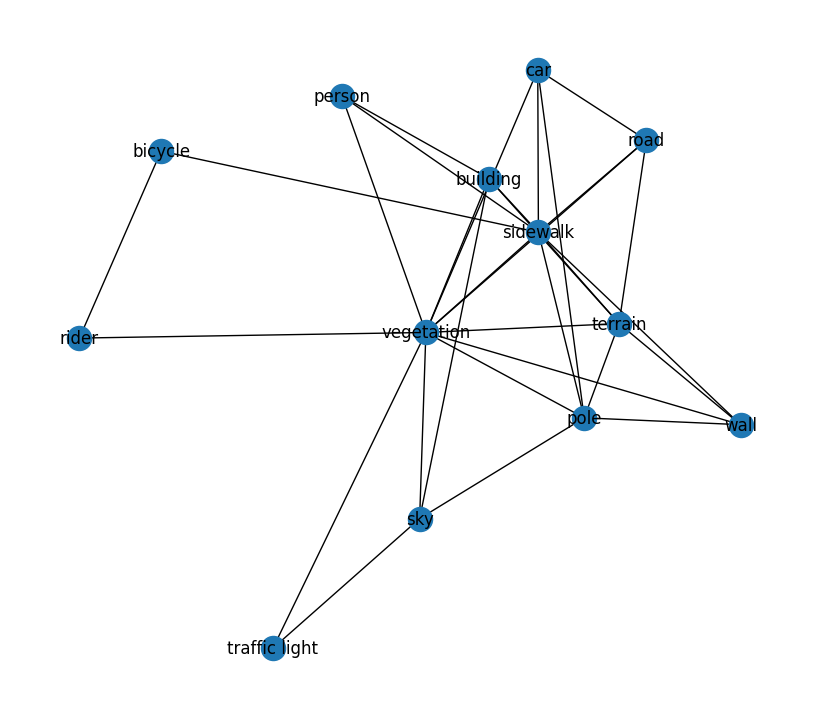

In [ ]:
img = "F:/桌面/depth/114.252911513_30.5934747488.png"

G = create_graph(img)

pos = {i: G.nodes[i]['mask_center'] for i in G.nodes()}
labels = {i: G.nodes[i]['label_id'] for i in G.nodes()}

plt.figure(figsize=(8, 7))
pos = nx.spring_layout(G, iterations=10)
nx.draw(G, pos, labels=labels, with_labels=True, node_size=300)
plt.show()

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

seg = get_prediction(img)["segmentation"].numpy()
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.1 + color_seg * 0.9
img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]